## Assignment 2
# Group 13
Mathieu Mailhot - Isabel Lougheed - Frank-Lucas Pantazis

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv
import os

## Checkout link: https://www.analyticsvidhya.com/blog/2021/11/a-guide-to-building-an-end-to-end-multiclass-text-classification-model/

In [62]:
# Hyperparameter
folds = 5 # between 5 and 10

# Loading Training data
df_train = pd.read_csv('train.csv', encoding='utf-8', encoding_errors='ignore') # errors were not pertinent characters
df_train["subreddit"] = df_train["subreddit"].map({"Boston": 0, "Canberra": 1,"Geneva":2,"Ottawa":3})

y = df_train["subreddit"]
X = df_train.drop("subreddit",axis=1)

# Loading Test Data
df_test = pd.read_csv('test.csv', encoding='utf-8', encoding_errors='ignore') # errors were not pertinent characters
X_test = df_test["body"] # Not what we should do with the ID

<h2>Text Preprocessing</h2>

In [ ]:
# Test different stop word libraries

# Checkout: https://towardsdatascience.com/text-pre-processing-stop-words-removal-using-different-libraries-f20bac19929a/

<h3>Train</h3>

In [94]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# Observations
# - bigram -> worse performance
# - sublinear_tf -> seems to improve accuracy
# - decreasing max_features -> seems to decrease accuracy (feature reduction)

# TODO
# - Create custom stop word list since default one might not be suited for our case according to documentation: https://scikit-learn.org/stable/modules/feature_extraction.html#stop-words
# - explore different ways to extract features from text data
stop_words = {"like"}

tfidf_uni = TfidfVectorizer(ngram_range=(1, 1), sublinear_tf=True, stop_words='english')
tfidf_uni_bi = TfidfVectorizer(ngram_range=(1, 2),sublinear_tf=True, stop_words='english')
tfidf_bi = TfidfVectorizer(ngram_range=(2, 2),  stop_words='english')

X_uni = tfidf_uni.fit_transform(df_train["body"]).toarray()
X_uni_bi = tfidf_uni_bi.fit_transform(df_train["body"]).toarray()
X_bi = tfidf_bi.fit_transform(df_train["body"]).toarray()

print("Unigram", "(size:",str(len(tfidf_uni.get_feature_names_out()))+")\n",tfidf_uni.get_feature_names_out(),"\n")
print("Unigram & Bigram", "(size:",str(len(tfidf_uni_bi.get_feature_names_out()))+")\n",tfidf_uni_bi.get_feature_names_out(),"\n")
print("Bigram", "(size:",str(len(tfidf_bi.get_feature_names_out()))+")\n", tfidf_bi.get_feature_names_out())

# To get a better idea of the extracted features
with open("features.csv", mode='w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    # Write a header (optional, if you want)
    writer.writerow(["Feature Name"])
    # Write the features from the array
    for feature in tfidf_uni.get_feature_names_out():
        writer.writerow([feature])

Unigram (size: 12557)
 ['00' '000' '0001' ... 'zucchini' 'zurich' 'zxwr7mvro1z3kabb'] 

Unigram & Bigram (size: 62167)
 ['00' '00 33' '00 avec' ... 'zurich tried' 'zxwr7mvro1z3kabb'
 'zxwr7mvro1z3kabb year'] 

Bigram (size: 49610)
 ['00 33' '00 avec' '00 bit' ... 'zurich migrations' 'zurich tried'
 'zxwr7mvro1z3kabb year']


CountVectorizer(stop_words='english')


KeyboardInterrupt: 

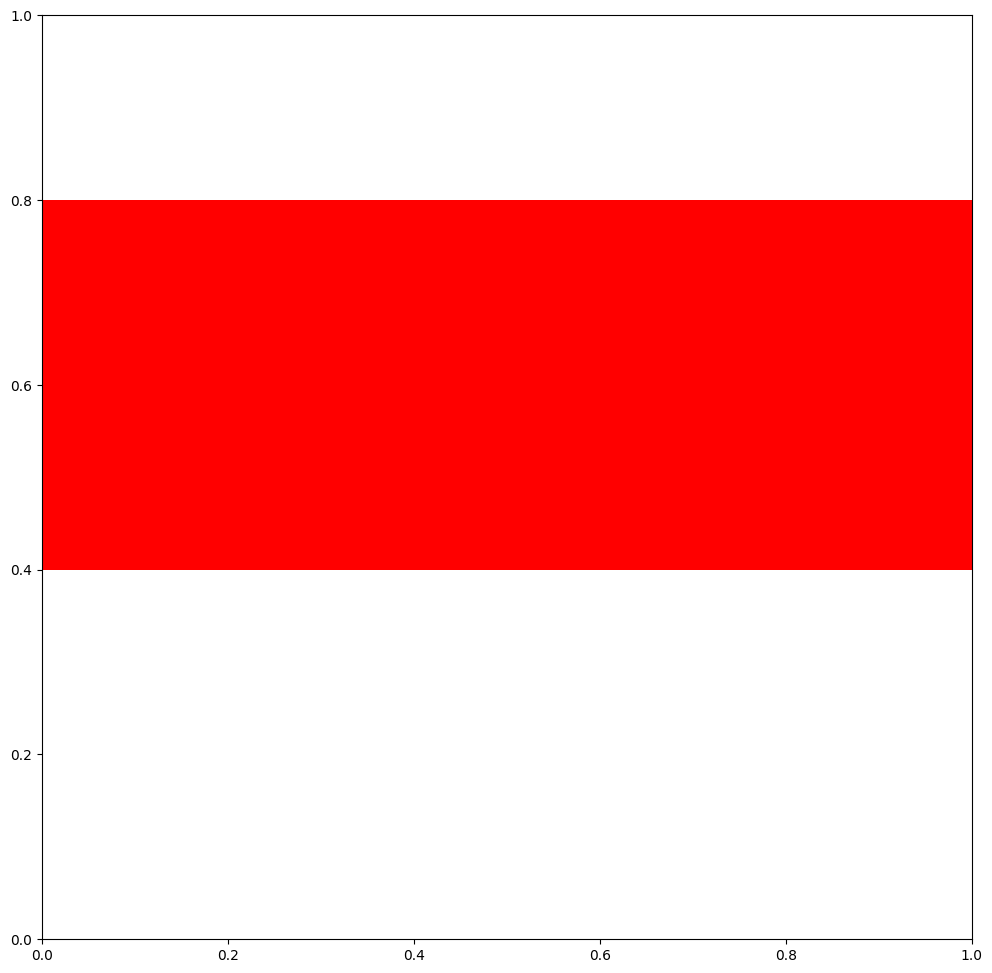

In [ ]:
# Draft of Feature Visualizer
# Maybe should put all of it in an excel and then display it?
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english')

X_disp = vectorizer.fit_transform(df_train["body"])
# Get feature names (words)
feature_names = vectorizer.get_feature_names_out()

Boston_counts = X_disp[y == 0].sum(axis=0).A1 # Sum occurrences for class 'Boston'
Canberra_counts = X_disp[y == 1].sum(axis=0).A1 # Sum occurrences for class 'Canberra'
Geneva_counts = X_disp[y == 2].sum(axis=0).A1 # Sum occurrences for class 'Geneva'
Ottawa_counts = X_disp[y == 3].sum(axis=0).A1 # Sum occurrences for class 'Ottawa'

# Plot a grouped bar chart
y_pos = np.arange(len(feature_names))*2 # Word indices
width = 0.4  # Bar width

fig, ax = plt.subplots(figsize=(12, 12))

ax.barh(y_pos + 3*width/2, Boston_counts, width, label="Boston", color='red')
ax.barh(y_pos + width/2, Canberra_counts, width, label="Canberra", color='orange')
ax.barh(y_pos - width/2, Geneva_counts, width, label="Geneva", color='blue')
ax.barh(y_pos - 3*width/2, Ottawa_counts, width, label="Ottawa", color='green')
# Formatting
ax.set_yticks(y_pos, labels=feature_names)

ax.set_xlabel("Word Count")
ax.set_title("Feature Appearance in Each Class")
ax.legend()

plt.show()



<h3>Helper Functions</h3>

In [54]:
import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# This function does all the tunning for each model
def hyperparamaterTunning(X, param, folds, model):
    
    model_gridSearch = GridSearchCV(model, param_grid=param,cv=folds, verbose=True) # According to doc the data will be split the same way accross all calls

    model_best_clf = model_gridSearch.fit(X,y)

    cv_results = model_gridSearch.cv_results_

    print(f"Best Parameters: {model_best_clf.best_params_}")
    try:

        best_index = model_gridSearch.best_index_

        scores = model_gridSearch.cv_results_[f"split{best_index}_test_score"]

        print()
    except:
        pass
   

    print(f"Cross-validation Accuracies: {scores}")

    print(f"Mean Accuracy: {model_best_clf.best_score_:.4f}")

    return model_best_clf


<h2>Naive Bayes</h2>

In [40]:
class naiveBayes:
    def __init__(self, x_all, y_all):
        self.x_all = x_all
        self.y_all = y_all
        self.features_probability = dict()

        self.folds_features_probability = 0 # array of dict
        self.folds_accuracy = 0
        self.avg_accuracy = 0

    
    def calc_probability(self): # Train/Fit # Mathieu
        pass
    
    def predict(self, x_i): # Issy
        pass # return y (0,1,2,3)

    def accu_eval(self, x, y): # Issy
        pass

    def crossValidation(self, k): # Issy (PS: I think we are allowed to use the method from sklearn)
        pass


In [45]:
# Compare with Naive Bayes model from sklearn
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

param_grid_NB_1 = {'alpha': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0]}

NB = hyperparamaterTunning(X_uni, param,folds, MultinomialNB())

Fitting 5 folds for each of 6 candidates, totalling 30 fits

Best Parameters: {'alpha': 5.0}
Cross-validation Accuracies: [0.69642857 0.73214286 0.75357143 0.73214286 0.72857143 0.725     ]
Mean Accuracy: 0.7079


<h2>Logistic Regression Models</h2>

In [48]:
from sklearn.linear_model import LogisticRegression

param_grid_logModel_1 = [
    {"penalty":["elasticnet"],
     "l1_ratio": np.arange(0, 1.2, 0.2), # 0 is only l2 penalty, 1 is only l1 penalty
     "solver":["saga"],
     "max_iter": [1000]
     }]

logModel_tunned_1 = hyperparamaterTunning(X_uni, param_grid_logModel_1, folds, LogisticRegression(fit_intercept=True))

Fitting 5 folds for each of 6 candidates, totalling 30 fits

Best Parameters: {'l1_ratio': np.float64(0.0), 'max_iter': 1000, 'penalty': 'elasticnet', 'solver': 'saga'}
Cross-validation Accuracies: [0.70714286 0.65       0.66428571 0.62142857 0.575      0.53571429]
Mean Accuracy: 0.7050


In [49]:
from sklearn.linear_model import LogisticRegression

param_grid_logModel_2 = [
    {"penalty":["l2"],
     "solver":["sag","lbfgs","newton-cg"],
     "tol":[1e-4,1e-5],
     "max_iter": [1000,2000]
     }]
logModel_tunned_2 = hyperparamaterTunning(X_uni, param_grid_logModel_2, folds, LogisticRegression(fit_intercept=True))

Fitting 5 folds for each of 12 candidates, totalling 60 fits

Best Parameters: {'max_iter': 1000, 'penalty': 'l2', 'solver': 'sag', 'tol': 0.0001}
Cross-validation Accuracies: [0.70714286 0.70714286 0.70714286 0.70714286 0.70714286 0.70714286
 0.70714286 0.70714286 0.70714286 0.70714286 0.70714286 0.70714286]
Mean Accuracy: 0.7050


<h2>Linear SVC Models</h2>

In [50]:
from sklearn.svm import LinearSVC
param_grid_SVC_1 = [
    {"penalty":["l1","l2"],
     "loss": ["squared_hinge"],
     "tol":[1e-4,1e-5],
     "max_iter": [1000]
     }]

SVMModel_tunned_1 = hyperparamaterTunning(X_uni, param_grid_SVC_1, folds, LinearSVC(fit_intercept=True))

Fitting 5 folds for each of 4 candidates, totalling 20 fits

Best Parameters: {'loss': 'squared_hinge', 'max_iter': 1000, 'penalty': 'l2', 'tol': 0.0001}
Cross-validation Accuracies: [0.69285714 0.69285714 0.69285714 0.69285714]
Mean Accuracy: 0.7093


In [51]:
from sklearn.svm import LinearSVC
param_grid_SVC_2 = [
    {"penalty":["l2"],
     "loss": ["hinge","squared_hinge"],
     "tol":[1e-4,1e-5],
     "max_iter": [1000]
     }]

SVMModel_tunned_2 = hyperparamaterTunning(X_uni_bi, param_grid_SVC_2, folds, LinearSVC(fit_intercept=True))

Fitting 5 folds for each of 4 candidates, totalling 20 fits

Best Parameters: {'loss': 'squared_hinge', 'max_iter': 1000, 'penalty': 'l2', 'tol': 0.0001}
Cross-validation Accuracies: [0.70714286 0.70714286 0.71428571 0.71428571]
Mean Accuracy: 0.7143


<h2>Random Forest Model</h2>

In [ ]:
from sklearn.ensemble import RandomForestClassifier

param_grid_rf = [{
"criterion":["gini", "entropy", "log_loss"],
"max_features":["sqrt", "log2"],
"max_depth": range(10,20) # Need to look into what values to use here
}]
rF = hyperparamaterTunning(X_uni, param_grid_rf, folds, RandomForestClassifier())